In [14]:
try:
    from tools.utils import EnvironmentDirOptions
except:
    !wget --no-cache -O utils.py -q https://raw.githubusercontent.com/aclicona/Utils/main/MachineLearning/utils.py
    from utils import EnvironmentDirOptions

In [15]:
github_repo_path = "https://github.com/MoisesGuerreroUdeA/Monografia/archive/refs/heads/main-licona.zip"
repo_name = "Monografia"
env_token_key = "GITHUB_TOKEN"
env_dir_options = EnvironmentDirOptions()
env_dir_options.get_repo_from_git(github_repo_path, repo_name, env_token_key)
main_dir = env_dir_options.main_dir

In [16]:
import os
import pandas as pd
from keras import backend
import json
import shutil
os.environ['LOG_LEVEL'] = 'INFO'
from tools.model_generation.generator import Generator
from tools.model_generation.trainer import Trainer
from tools.model_generation.evaluator import ModelEvaluator
from tools.utils import DataSelectionForEvaluator, load_scaler, save_scaler
from sklearn.model_selection import TimeSeriesSplit

In [17]:
dataset = pd.read_feather(os.path.join(main_dir, 'data', 'dataset.feather'))

In [18]:
json_config_path = os.path.join(main_dir, "config/config_models_cross.json")
file = open(json_config_path, 'r')
model_configurations = json.load(file)

model_generator = Generator()
trainer = Trainer()
model_save_dir = env_dir_options.save_dir_path("models_cross/")
n_splits = 10 # The number of splits or folds for cross validation
tscv = TimeSeriesSplit(n_splits=n_splits)

In [19]:
    
for model_conf in model_configurations:
        backend.clear_session()
        model = model_generator.generate_model(model_conf)
        training_params, scaler_x, scaler_y = trainer.train_model_params(model_conf, dataset, model_save_dir)
        
        X, Y = training_params['x'], training_params['y']
        previous_history = {}
        best_val_loss = float('inf')
        
        for fold_no, (train_index, test_index) in enumerate(tscv.split(X), start=1):
            x_train, x_test = X[train_index], X[test_index]
            y_train, y_test = Y[train_index], Y[test_index]
            
            training_params['x'] = x_train
            training_params['y'] = y_train
            training_params['validation_data'] = (x_test, y_test)
            
            if fold_no > 1:
                best_model_path = os.path.join(model_save_dir, f'{model_conf["model"]["name"]}_best.keras')
                best_model = env_dir_options.load_model(best_model_path)
                model.set_weights(best_model.get_weights())
            
            history = model.fit(**training_params)
            
            # Update the history
            for key, value in history.history.items():
                if key in previous_history:
                    previous_history[key].extend(value)
                else:
                    previous_history[key] = value
            
            # Save history
            trainer.save_history(model.name, previous_history, model_save_dir)
            
            # Save the best model
            current_val_loss = min(history.history['val_loss'])
            if current_val_loss < best_val_loss:
                best_val_loss = current_val_loss
                best_model_path = os.path.join(model_save_dir, f'{model_conf["model"]["name"]}_best.keras')
                current_model_path = os.path.join(model_save_dir, f'{model_conf["model"]["name"]}.keras')
                shutil.copy2(current_model_path, best_model_path)
        
        # Save scalers
        save_scaler(scaler_x, os.path.join(model_save_dir, f'{model.name}_scaler_x.pkl'))
        save_scaler(scaler_y, os.path.join(model_save_dir, f'{model.name}_scaler_y.pkl'))


2024-06-10 19:06:39,848 INFO Adding a Input layer to the model with name None
2024-06-10 19:06:39,849 INFO Configuring input shape = (48, 11)
2024-06-10 19:06:39,850 INFO Adding a Simple_rnn layer to the model with name None
2024-06-10 19:06:39,957 INFO Adding a Dropout layer to the model with name None
2024-06-10 19:06:39,959 INFO Adding a Simple_rnn layer to the model with name None
2024-06-10 19:06:39,966 INFO Adding a Dropout layer to the model with name None
2024-06-10 19:06:39,970 INFO Adding a Simple_rnn layer to the model with name None
2024-06-10 19:06:39,983 INFO Adding a Dropout layer to the model with name None
2024-06-10 19:06:39,987 INFO Adding a Simple_rnn layer to the model with name None
2024-06-10 19:06:39,995 INFO Adding a Dropout layer to the model with name None
2024-06-10 19:06:39,998 INFO Adding a Dense layer to the model with name None


Model: "RNN_2_look48_overlap48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 48, 256)        │        35,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 48, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 48, 256)        │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 48, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 128)            │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 48)             │         6,192 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,384 (806.19 KB)

 Trainable params: 206,384 (806.19 KB)

 Non-trainable params: 0 (0.00 B)

2024-06-10 19:06:40,026 INFO Starting training for all available models...
2024-06-10 19:06:40,027 INFO Generating a scaled dataset by using MinMaxScaler...
2024-06-10 19:06:40,027 INFO The dataset includes columns: ['GHI', 'wind_dir', 'humidity', 'precipitation', 'air_temp', 'wind_sp', 'sun_elev', 'sun_azim', 'total_minutes_day', 'day_of_year', 'attenuation_index']
2024-06-10 19:06:40,061 WARNING Output column should by the first column on dataset!
2024-06-10 19:06:40,065 INFO Splitting data into train and test datasets with test size: 0.3
2024-06-10 19:06:40,076 INFO 
-----------------------------
X Train shape: (2299, 48, 11) 
y Train shape: (2299, 48) 
X Test shape: (985, 48, 11) 
y Test shape: (985, 48) 
-----------------------------

2024-06-10 19:06:40,077 INFO Model with name RNN_2_look48_overlap48 will be saved on directory ./data/models_trained_cross...


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - loss: 0.2798 - mae: 0.6201 - mse: 0.6079 - val_loss: 0.0761 - val_mae: 0.2872 - val_mse: 0.1542
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.1973 - mae: 0.5121 - mse: 0.4109 - val_loss: 0.0417 - val_mae: 0.2294 - val_mse: 0.0834
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.1715 - mae: 0.4742 - mse: 0.3526 - val_loss: 0.0324 - val_mae: 0.1971 - val_mse: 0.0649
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.1584 - mae: 0.4536 - mse: 0.3250 - val_loss: 0.0298 - val_mae: 0.1898 - val_mse: 0.0597
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.1517 - mae: 0.4437 - mse: 0.3103 - val_loss: 0.0209 - val_mae: 0.1591 - val_mse: 0.0417
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.1425 - mae: 0.4304 - mse: 0.2899 - val_loss: 0.0263 - val_mae: 0.1698 - val_mse: 0.0527
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.1401 - mae: 0.4236 - mse: 0.2850 - val_loss: 0.0223 - val_

2024-06-10 19:06:46,818 INFO Saving model RNN_2_look48_overlap48 history on directory ./data/models_trained_cross
2024-06-10 19:06:46,819 INFO History file was successfully wrote for model RNN_2_look48_overlap48!


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.1424 - mae: 0.4292 - mse: 0.2903 - val_loss: 0.0409 - val_mae: 0.2257 - val_mse: 0.0818
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.1455 - mae: 0.4357 - mse: 0.2963 - val_loss: 0.0364 - val_mae: 0.2158 - val_mse: 0.0728
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.1390 - mae: 0.4250 - mse: 0.2826 - val_loss: 0.0406 - val_mae: 0.2309 - val_mse: 0.0813
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.1337 - mae: 0.4153 - mse: 0.2720 - val_loss: 0.0393 - val_mae: 0.2198 - val_mse: 0.0786
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.1300 - mae: 0.4072 - mse: 0.2643 - val_loss: 0.0313 - val_mae: 0.1917 - val_mse: 0.0625


2024-06-10 19:06:51,930 INFO Saving model RNN_2_look48_overlap48 history on directory ./data/models_trained_cross
2024-06-10 19:06:51,930 INFO History file was successfully wrote for model RNN_2_look48_overlap48!


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.1477 - mae: 0.4371 - mse: 0.3017 - val_loss: 0.0415 - val_mae: 0.2365 - val_mse: 0.0830
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.1412 - mae: 0.4277 - mse: 0.2872 - val_loss: 0.0314 - val_mae: 0.1893 - val_mse: 0.0628
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.1284 - mae: 0.4065 - mse: 0.2603 - val_loss: 0.0357 - val_mae: 0.2061 - val_mse: 0.0713
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.1175 - mae: 0.3887 - mse: 0.2374 - val_loss: 0.0354 - val_mae: 0.2012 - val_mse: 0.0707
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.1049 - mae: 0.3657 - mse: 0.2115 - val_loss: 0.0336 - val_mae: 0.1963 - val_mse: 0.0672


2024-06-10 19:06:58,870 INFO Saving model RNN_2_look48_overlap48 history on directory ./data/models_trained_cross
2024-06-10 19:06:58,871 INFO History file was successfully wrote for model RNN_2_look48_overlap48!


Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.1410 - mae: 0.4274 - mse: 0.2871 - val_loss: 0.0350 - val_mae: 0.2122 - val_mse: 0.0700
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.1338 - mae: 0.4156 - mse: 0.2717 - val_loss: 0.0377 - val_mae: 0.2217 - val_mse: 0.0753
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.1176 - mae: 0.3881 - mse: 0.2377 - val_loss: 0.0293 - val_mae: 0.1961 - val_mse: 0.0587
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.1087 - mae: 0.3720 - mse: 0.2192 - val_loss: 0.0538 - val_mae: 0.2621 - val_mse: 0.1075
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0849 - mae: 0.3281 - mse: 0.1706 - val_loss: 0.0331 - val_mae: 0.2055 - val_mse: 0.0661


2024-06-10 19:07:08,176 INFO Saving model RNN_2_look48_overlap48 history on directory ./data/models_trained_cross
2024-06-10 19:07:08,177 INFO History file was successfully wrote for model RNN_2_look48_overlap48!


Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.1462 - mae: 0.4343 - mse: 0.2984 - val_loss: 0.0215 - val_mae: 0.1635 - val_mse: 0.0429
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.1317 - mae: 0.4121 - mse: 0.2675 - val_loss: 0.0264 - val_mae: 0.1771 - val_mse: 0.0528
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.1097 - mae: 0.3748 - mse: 0.2213 - val_loss: 0.0298 - val_mae: 0.1937 - val_mse: 0.0596
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0995 - mae: 0.3563 - mse: 0.2002 - val_loss: 0.0306 - val_mae: 0.1896 - val_mse: 0.0612
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0735 - mae: 0.3039 - mse: 0.1474 - val_loss: 0.0261 - val_mae: 0.1761 - val_mse: 0.0522


2024-06-10 19:07:19,266 INFO Saving model RNN_2_look48_overlap48 history on directory ./data/models_trained_cross
2024-06-10 19:07:19,268 INFO History file was successfully wrote for model RNN_2_look48_overlap48!


Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.1449 - mae: 0.4330 - mse: 0.2954 - val_loss: 0.0329 - val_mae: 0.2067 - val_mse: 0.0657
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.1315 - mae: 0.4108 - mse: 0.2669 - val_loss: 0.0265 - val_mae: 0.1794 - val_mse: 0.0531
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.1058 - mae: 0.3674 - mse: 0.2133 - val_loss: 0.0273 - val_mae: 0.1879 - val_mse: 0.0546
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0767 - mae: 0.3111 - mse: 0.1537 - val_loss: 0.0259 - val_mae: 0.1705 - val_mse: 0.0517
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0612 - mae: 0.2767 - mse: 0.1225 - val_loss: 0.0194 - val_mae: 0.1480 - val_mse: 0.0389
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 0.0448 - mae: 0.2367 - mse: 0.0895 - val_loss: 0.0255 - val_mae: 0.1652 - val_mse: 0.0511
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0431 - mae: 0.2309 - mse: 0.0862 - val_loss: 

2024-06-10 19:08:35,269 INFO Saving model RNN_2_look48_overlap48 history on directory ./data/models_trained_cross
2024-06-10 19:08:35,271 INFO History file was successfully wrote for model RNN_2_look48_overlap48!


Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.0087 - mae: 0.0962 - mse: 0.0173 - val_loss: 0.0076 - val_mae: 0.0862 - val_mse: 0.0151
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.0156 - mae: 0.1294 - mse: 0.0311 - val_loss: 0.0135 - val_mae: 0.1137 - val_mse: 0.0271
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0162 - mae: 0.1346 - mse: 0.0324 - val_loss: 0.0086 - val_mae: 0.0952 - val_mse: 0.0173
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0147 - mae: 0.1277 - mse: 0.0294 - val_loss: 0.0176 - val_mae: 0.1388 - val_mse: 0.0352
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0177 - mae: 0.1386 - mse: 0.0353 - val_loss: 0.0079 - val_mae: 0.0934 - val_mse: 0.0158


2024-06-10 19:08:50,404 INFO Saving model RNN_2_look48_overlap48 history on directory ./data/models_trained_cross
2024-06-10 19:08:50,405 INFO History file was successfully wrote for model RNN_2_look48_overlap48!


Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0095 - mae: 0.1012 - mse: 0.0190 - val_loss: 0.0206 - val_mae: 0.1447 - val_mse: 0.0412
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0137 - mae: 0.1211 - mse: 0.0275 - val_loss: 0.0196 - val_mae: 0.1274 - val_mse: 0.0393
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0117 - mae: 0.1112 - mse: 0.0235 - val_loss: 0.0062 - val_mae: 0.0826 - val_mse: 0.0123
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 0.0108 - mae: 0.1083 - mse: 0.0217 - val_loss: 0.0139 - val_mae: 0.1097 - val_mse: 0.0278
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0118 - mae: 0.1112 - mse: 0.0235 - val_loss: 0.0074 - val_mae: 0.0859 - val_mse: 0.0148


2024-06-10 19:09:07,033 INFO Saving model RNN_2_look48_overlap48 history on directory ./data/models_trained_cross
2024-06-10 19:09:07,035 INFO History file was successfully wrote for model RNN_2_look48_overlap48!


Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0091 - mae: 0.0994 - mse: 0.0182 - val_loss: 0.0310 - val_mae: 0.1833 - val_mse: 0.0620
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0218 - mae: 0.1555 - mse: 0.0435 - val_loss: 0.0105 - val_mae: 0.1048 - val_mse: 0.0210
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.0143 - mae: 0.1288 - mse: 0.0287 - val_loss: 0.0130 - val_mae: 0.1220 - val_mse: 0.0261
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0126 - mae: 0.1181 - mse: 0.0252 - val_loss: 0.0107 - val_mae: 0.1036 - val_mse: 0.0213
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0106 - mae: 0.1055 - mse: 0.0211 - val_loss: 0.0118 - val_mae: 0.1051 - val_mse: 0.0236


2024-06-10 19:09:25,975 INFO Saving model RNN_2_look48_overlap48 history on directory ./data/models_trained_cross
2024-06-10 19:09:25,976 INFO History file was successfully wrote for model RNN_2_look48_overlap48!


Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0090 - mae: 0.0984 - mse: 0.0181 - val_loss: 0.0207 - val_mae: 0.1550 - val_mse: 0.0413
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0204 - mae: 0.1519 - mse: 0.0408 - val_loss: 0.0119 - val_mae: 0.1117 - val_mse: 0.0237
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.0161 - mae: 0.1323 - mse: 0.0322 - val_loss: 0.0105 - val_mae: 0.1021 - val_mse: 0.0209
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.0136 - mae: 0.1221 - mse: 0.0272 - val_loss: 0.0144 - val_mae: 0.1142 - val_mse: 0.0289
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0106 - mae: 0.1039 - mse: 0.0211 - val_loss: 0.0122 - val_mae: 0.1019 - val_mse: 0.0244


2024-06-10 19:09:46,823 INFO Saving model RNN_2_look48_overlap48 history on directory ./data/models_trained_cross
2024-06-10 19:09:46,825 INFO History file was successfully wrote for model RNN_2_look48_overlap48!
2024-06-10 19:09:47,163 INFO Adding a Input layer to the model with name input_1
2024-06-10 19:09:47,163 INFO Configuring input shape = (72, 11)
2024-06-10 19:09:47,164 INFO Adding a Gru layer to the model with name gru_1
2024-06-10 19:09:47,185 INFO Adding a Dropout layer to the model with name dropout_1
2024-06-10 19:09:47,186 INFO Adding a Gru layer to the model with name gru_2
2024-06-10 19:09:47,195 INFO Adding a Dropout layer to the model with name dropout_2
2024-06-10 19:09:47,198 INFO Adding a Gru layer to the model with name gru_3
2024-06-10 19:09:47,207 INFO Adding a Dropout layer to the model with name dropout_3
2024-06-10 19:09:47,210 INFO Adding a Gru layer to the model with name gru_4
2024-06-10 19:09:47,217 INFO Adding a Dropout layer to the model with name drop

Model: "GRU_1_look72_overlap36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 72, 200)        │       127,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 72, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 72, 150)        │       158,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 72, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 72, 125)        │       103,875 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 72, 125)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 100)            │        68,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 48)             │         4,848 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 463,023 (1.77 MB)

 Trainable params: 463,023 (1.77 MB)

 Non-trainable params: 0 (0.00 B)

2024-06-10 19:09:47,232 INFO Starting training for all available models...
2024-06-10 19:09:47,233 INFO Generating a scaled dataset by using MinMaxScaler...
2024-06-10 19:09:47,233 INFO The dataset includes columns: ['GHI', 'wind_dir', 'humidity', 'precipitation', 'air_temp', 'wind_sp', 'sun_elev', 'sun_azim', 'total_minutes_day', 'day_of_year', 'attenuation_index']
2024-06-10 19:09:47,262 WARNING Output column should by the first column on dataset!
2024-06-10 19:09:47,264 INFO Splitting data into train and test datasets with test size: 0.3
2024-06-10 19:09:47,275 INFO 
-----------------------------
X Train shape: (3065, 72, 11) 
y Train shape: (3065, 48) 
X Test shape: (1312, 72, 11) 
y Test shape: (1312, 48) 
-----------------------------

2024-06-10 19:09:47,279 INFO Model with name GRU_1_look72_overlap36 will be saved on directory ./data/models_trained_cross...


Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 241ms/step - loss: 0.0268 - mae: 0.1410 - mse: 0.0536 - val_loss: 0.0333 - val_mae: 0.2198 - val_mse: 0.0665
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 202ms/step - loss: 0.0339 - mae: 0.2048 - mse: 0.0679 - val_loss: 0.0175 - val_mae: 0.1331 - val_mse: 0.0350
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step - loss: 0.0217 - mae: 0.1492 - mse: 0.0434 - val_loss: 0.0191 - val_mae: 0.1707 - val_mse: 0.0382
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - loss: 0.0223 - mae: 0.1756 - mse: 0.0447 - val_loss: 0.0169 - val_mae: 0.1580 - val_mse: 0.0337
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step - loss: 0.0185 - mae: 0.1559 - mse: 0.0371 - val_loss: 0.0194 - val_mae: 0.1591 - val_mse: 0.0388
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - loss: 0.0179 - mae: 0.1494 - mse: 0.0357 - val_loss: 0.0145 - val_mae: 0.1320 - val_mse: 0.0289
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step - loss: 0.0131 - mae: 0.1256 - mse: 0.0261 - val_loss: 0.0178 

2024-06-10 19:10:10,271 INFO Saving model GRU_1_look72_overlap36 history on directory ./data/models_trained_cross
2024-06-10 19:10:10,273 INFO History file was successfully wrote for model GRU_1_look72_overlap36!


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - loss: 0.0159 - mae: 0.1349 - mse: 0.0317 - val_loss: 0.0342 - val_mae: 0.1781 - val_mse: 0.0684
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step - loss: 0.0212 - mae: 0.1302 - mse: 0.0425 - val_loss: 0.0256 - val_mae: 0.1573 - val_mse: 0.0513
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - loss: 0.0131 - mae: 0.1159 - mse: 0.0261 - val_loss: 0.0200 - val_mae: 0.1450 - val_mse: 0.0401
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 196ms/step - loss: 0.0137 - mae: 0.1177 - mse: 0.0274 - val_loss: 0.0179 - val_mae: 0.1328 - val_mse: 0.0358
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 202ms/step - loss: 0.0131 - mae: 0.1146 - mse: 0.0261 - val_loss: 0.0142 - val_mae: 0.1185 - val_mse: 0.0284
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - loss: 0.0120 - mae: 0.1091 - mse: 0.0241 - val_loss: 0.0169 - val_mae: 0.1286 - val_mse: 0.0339
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - loss: 0.0116 - mae: 0.1089 - mse: 0.0233 - val

2024-06-10 19:11:32,610 INFO Saving model GRU_1_look72_overlap36 history on directory ./data/models_trained_cross
2024-06-10 19:11:32,612 INFO History file was successfully wrote for model GRU_1_look72_overlap36!


Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - loss: 0.0062 - mae: 0.0776 - mse: 0.0123 - val_loss: 0.0042 - val_mae: 0.0613 - val_mse: 0.0083
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 182ms/step - loss: 0.0059 - mae: 0.0771 - mse: 0.0118 - val_loss: 0.0035 - val_mae: 0.0567 - val_mse: 0.0070
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 180ms/step - loss: 0.0054 - mae: 0.0725 - mse: 0.0108 - val_loss: 0.0033 - val_mae: 0.0545 - val_mse: 0.0066
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 188ms/step - loss: 0.0053 - mae: 0.0717 - mse: 0.0106 - val_loss: 0.0034 - val_mae: 0.0550 - val_mse: 0.0069
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step - loss: 0.0058 - mae: 0.0751 - mse: 0.0116 - val_loss: 0.0041 - val_mae: 0.0584 - val_mse: 0.0083
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 196ms/step - loss: 0.0061 - mae: 0.0750 - mse: 0.0123 - val_loss: 0.0058 - val_mae: 0.0697 - val_mse: 0.0117
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 183ms/step - loss: 0.0071 - mae: 0.0832 - mse: 0.0143 - val

2024-06-10 19:12:47,660 INFO Saving model GRU_1_look72_overlap36 history on directory ./data/models_trained_cross
2024-06-10 19:12:47,662 INFO History file was successfully wrote for model GRU_1_look72_overlap36!


Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 178ms/step - loss: 0.0045 - mae: 0.0645 - mse: 0.0090 - val_loss: 0.0056 - val_mae: 0.0686 - val_mse: 0.0111
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 184ms/step - loss: 0.0050 - mae: 0.0671 - mse: 0.0100 - val_loss: 0.0057 - val_mae: 0.0617 - val_mse: 0.0113
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 187ms/step - loss: 0.0052 - mae: 0.0665 - mse: 0.0104 - val_loss: 0.0082 - val_mae: 0.0843 - val_mse: 0.0164
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 190ms/step - loss: 0.0062 - mae: 0.0740 - mse: 0.0124 - val_loss: 0.0046 - val_mae: 0.0559 - val_mse: 0.0092
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step - loss: 0.0054 - mae: 0.0677 - mse: 0.0108 - val_loss: 0.0047 - val_mae: 0.0621 - val_mse: 0.0095


2024-06-10 19:13:20,241 INFO Saving model GRU_1_look72_overlap36 history on directory ./data/models_trained_cross
2024-06-10 19:13:20,243 INFO History file was successfully wrote for model GRU_1_look72_overlap36!


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 181ms/step - loss: 0.0048 - mae: 0.0661 - mse: 0.0095 - val_loss: 0.0045 - val_mae: 0.0560 - val_mse: 0.0090
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 184ms/step - loss: 0.0051 - mae: 0.0676 - mse: 0.0102 - val_loss: 0.0056 - val_mae: 0.0649 - val_mse: 0.0112
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 185ms/step - loss: 0.0067 - mae: 0.0774 - mse: 0.0134 - val_loss: 0.0059 - val_mae: 0.0642 - val_mse: 0.0118
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 187ms/step - loss: 0.0068 - mae: 0.0771 - mse: 0.0136 - val_loss: 0.0050 - val_mae: 0.0641 - val_mse: 0.0100
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 188ms/step - loss: 0.0060 - mae: 0.0738 - mse: 0.0120 - val_loss: 0.0043 - val_mae: 0.0571 - val_mse: 0.0085


2024-06-10 19:14:01,112 INFO Saving model GRU_1_look72_overlap36 history on directory ./data/models_trained_cross
2024-06-10 19:14:01,115 INFO History file was successfully wrote for model GRU_1_look72_overlap36!


Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 171ms/step - loss: 0.0049 - mae: 0.0673 - mse: 0.0097 - val_loss: 0.0035 - val_mae: 0.0514 - val_mse: 0.0070
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 170ms/step - loss: 0.0053 - mae: 0.0688 - mse: 0.0107 - val_loss: 0.0062 - val_mae: 0.0718 - val_mse: 0.0124
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 170ms/step - loss: 0.0059 - mae: 0.0712 - mse: 0.0118 - val_loss: 0.0043 - val_mae: 0.0601 - val_mse: 0.0086
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 169ms/step - loss: 0.0051 - mae: 0.0667 - mse: 0.0101 - val_loss: 0.0033 - val_mae: 0.0512 - val_mse: 0.0065
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 172ms/step - loss: 0.0048 - mae: 0.0650 - mse: 0.0097 - val_loss: 0.0033 - val_mae: 0.0493 - val_mse: 0.0066


2024-06-10 19:14:46,502 INFO Saving model GRU_1_look72_overlap36 history on directory ./data/models_trained_cross
2024-06-10 19:14:46,505 INFO History file was successfully wrote for model GRU_1_look72_overlap36!


Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0049 - mae: 0.0677 - mse: 0.0099 - val_loss: 0.0051 - val_mae: 0.0631 - val_mse: 0.0102
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0055 - mae: 0.0707 - mse: 0.0109 - val_loss: 0.0061 - val_mae: 0.0708 - val_mse: 0.0121
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 181ms/step - loss: 0.0066 - mae: 0.0761 - mse: 0.0133 - val_loss: 0.0100 - val_mae: 0.0866 - val_mse: 0.0200
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - loss: 0.0068 - mae: 0.0764 - mse: 0.0137 - val_loss: 0.0090 - val_mae: 0.0801 - val_mse: 0.0179
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - loss: 0.0060 - mae: 0.0713 - mse: 0.0119 - val_loss: 0.0056 - val_mae: 0.0609 - val_mse: 0.0112


2024-06-10 19:15:41,238 INFO Saving model GRU_1_look72_overlap36 history on directory ./data/models_trained_cross
2024-06-10 19:15:41,240 INFO History file was successfully wrote for model GRU_1_look72_overlap36!


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 169ms/step - loss: 0.0049 - mae: 0.0665 - mse: 0.0098 - val_loss: 0.0047 - val_mae: 0.0606 - val_mse: 0.0095
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 176ms/step - loss: 0.0061 - mae: 0.0744 - mse: 0.0122 - val_loss: 0.0046 - val_mae: 0.0607 - val_mse: 0.0093
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 13s 180ms/step - loss: 0.0064 - mae: 0.0753 - mse: 0.0128 - val_loss: 0.0038 - val_mae: 0.0537 - val_mse: 0.0076
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 13s 186ms/step - loss: 0.0049 - mae: 0.0645 - mse: 0.0097 - val_loss: 0.0044 - val_mae: 0.0562 - val_mse: 0.0087
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 13s 182ms/step - loss: 0.0065 - mae: 0.0723 - mse: 0.0129 - val_loss: 0.0030 - val_mae: 0.0450 - val_mse: 0.0060


2024-06-10 19:16:43,960 INFO Saving model GRU_1_look72_overlap36 history on directory ./data/models_trained_cross
2024-06-10 19:16:43,962 INFO History file was successfully wrote for model GRU_1_look72_overlap36!


Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 184ms/step - loss: 0.0051 - mae: 0.0683 - mse: 0.0102 - val_loss: 0.0080 - val_mae: 0.0829 - val_mse: 0.0161
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 186ms/step - loss: 0.0069 - mae: 0.0787 - mse: 0.0138 - val_loss: 0.0090 - val_mae: 0.0852 - val_mse: 0.0181
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 182ms/step - loss: 0.0052 - mae: 0.0673 - mse: 0.0103 - val_loss: 0.0088 - val_mae: 0.0796 - val_mse: 0.0175
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 200ms/step - loss: 0.0056 - mae: 0.0682 - mse: 0.0112 - val_loss: 0.0058 - val_mae: 0.0665 - val_mse: 0.0115
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 172ms/step - loss: 0.0049 - mae: 0.0644 - mse: 0.0097 - val_loss: 0.0068 - val_mae: 0.0769 - val_mse: 0.0137


2024-06-10 19:17:57,073 INFO Saving model GRU_1_look72_overlap36 history on directory ./data/models_trained_cross
2024-06-10 19:17:57,075 INFO History file was successfully wrote for model GRU_1_look72_overlap36!


Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 16s 178ms/step - loss: 0.0050 - mae: 0.0676 - mse: 0.0100 - val_loss: 0.0056 - val_mae: 0.0700 - val_mse: 0.0112
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 16s 179ms/step - loss: 0.0059 - mae: 0.0743 - mse: 0.0119 - val_loss: 0.0048 - val_mae: 0.0621 - val_mse: 0.0096
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 16s 178ms/step - loss: 0.0053 - mae: 0.0691 - mse: 0.0106 - val_loss: 0.0034 - val_mae: 0.0495 - val_mse: 0.0068
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 15s 176ms/step - loss: 0.0070 - mae: 0.0760 - mse: 0.0139 - val_loss: 0.0037 - val_mae: 0.0519 - val_mse: 0.0075
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 16s 177ms/step - loss: 0.0050 - mae: 0.0653 - mse: 0.0100 - val_loss: 0.0041 - val_mae: 0.0552 - val_mse: 0.0081


2024-06-10 19:19:15,581 INFO Saving model GRU_1_look72_overlap36 history on directory ./data/models_trained_cross
2024-06-10 19:19:15,584 INFO History file was successfully wrote for model GRU_1_look72_overlap36!


Scaler loaded using joblib from ./data/models_trained_cross/RNN_2_look48_overlap48_scaler_x.pkl
Scaler loaded using joblib from ./data/models_trained_cross/RNN_2_look48_overlap48_scaler_y.pkl
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


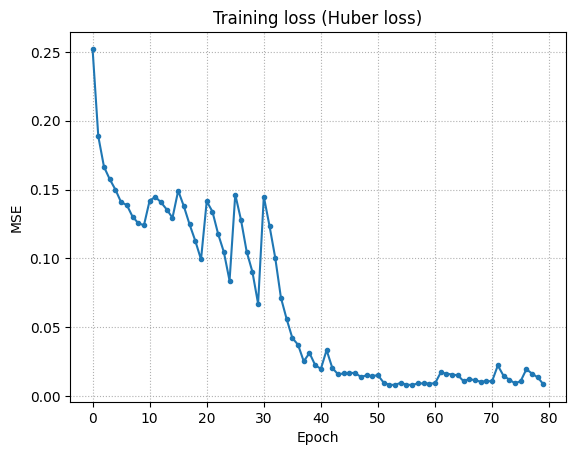

MSE = 312.956844
RMSE = 97941.986215
MAPE = 201.458047
sMAPE = 168.356676
MAE = 246.787741
Huber loss = 246.287735


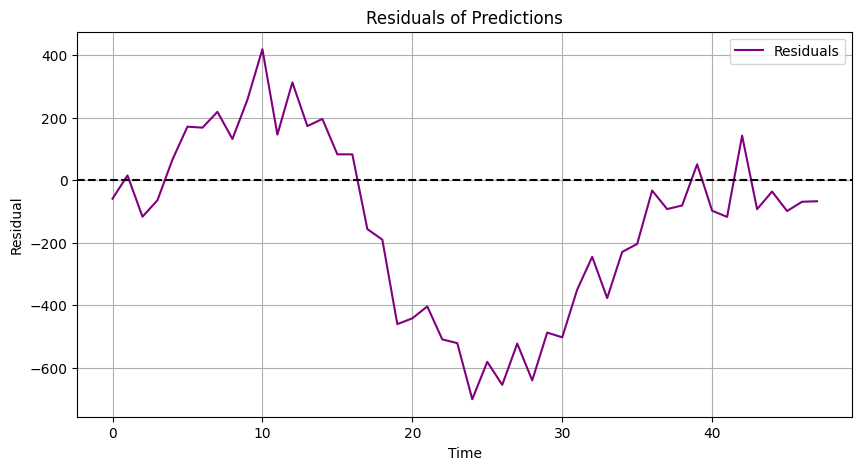

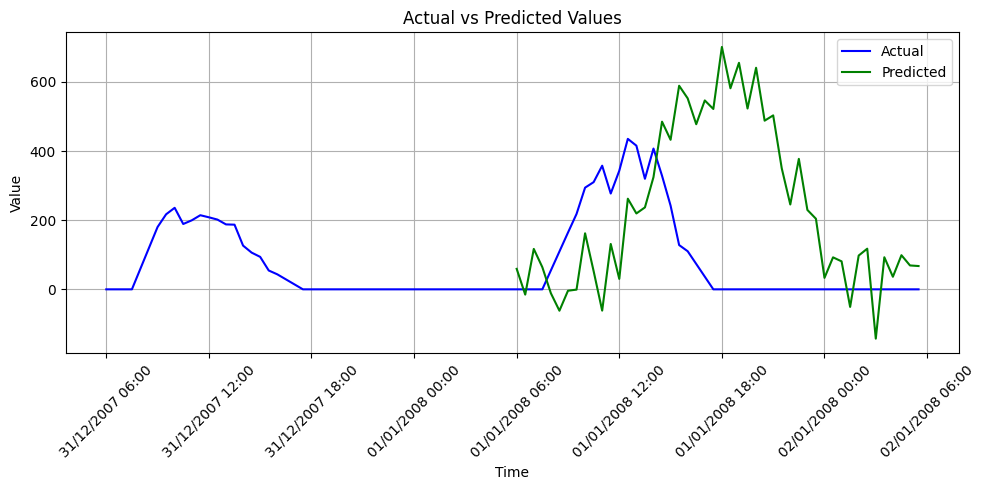

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
MSE = 386.581435
RMSE = 149445.205876
MAPE = 291.356917
sMAPE = 153.570961
MAE = 314.091991
Huber loss = 313.592010


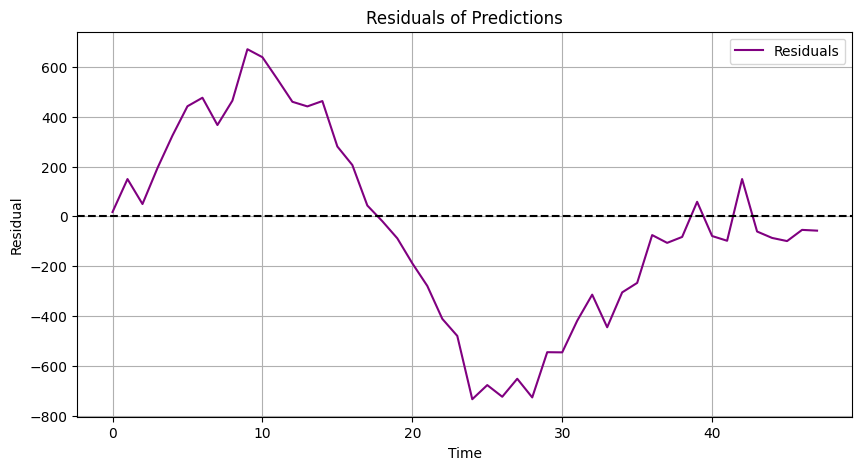

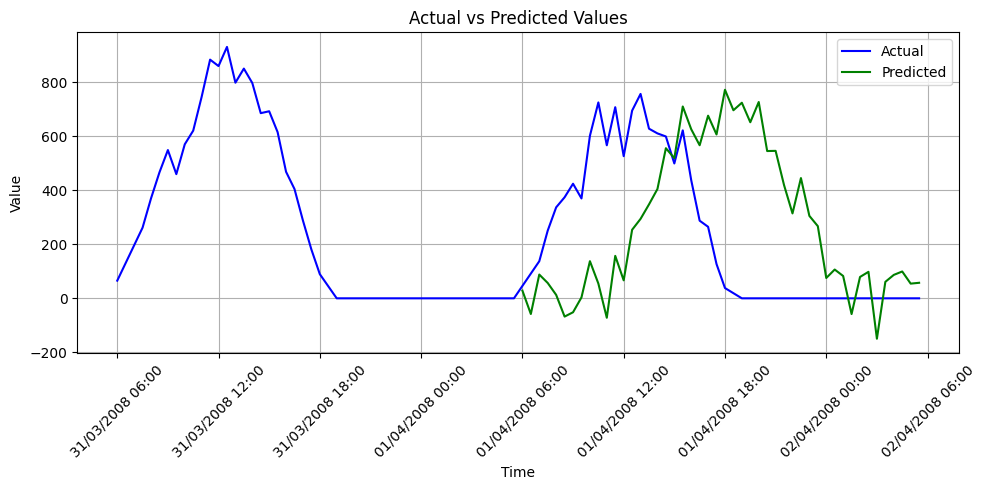

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
MSE = 511.391182
RMSE = 261520.940916
MAPE = 257.871284
sMAPE = 149.794621
MAE = 427.782981
Huber loss = 427.282990


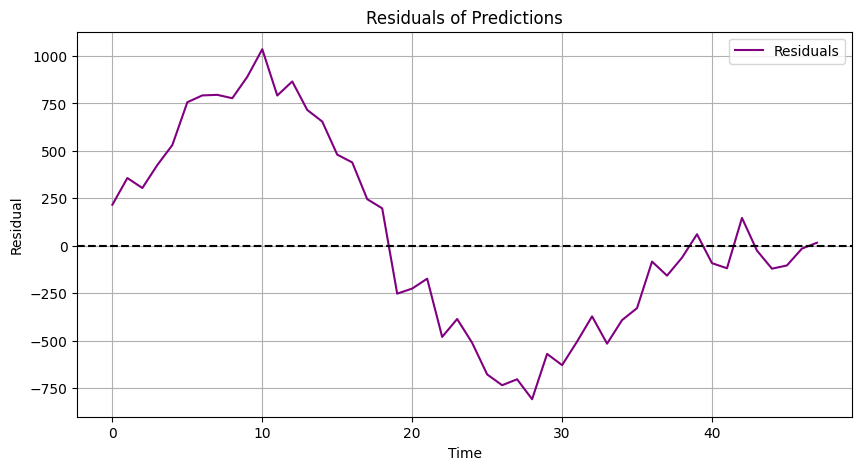

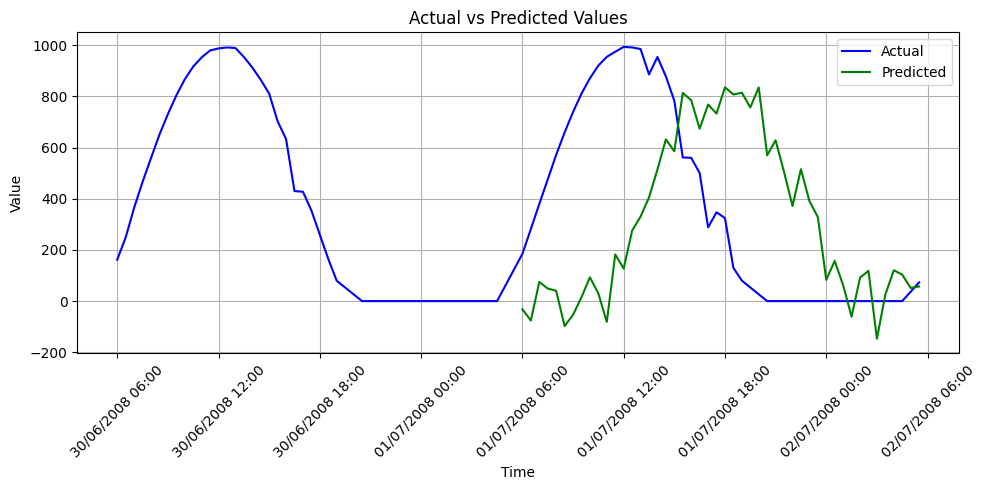

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
MSE = 429.515229
RMSE = 184483.332282
MAPE = 211.022434
sMAPE = 162.791636
MAE = 349.457885
Huber loss = 348.957855


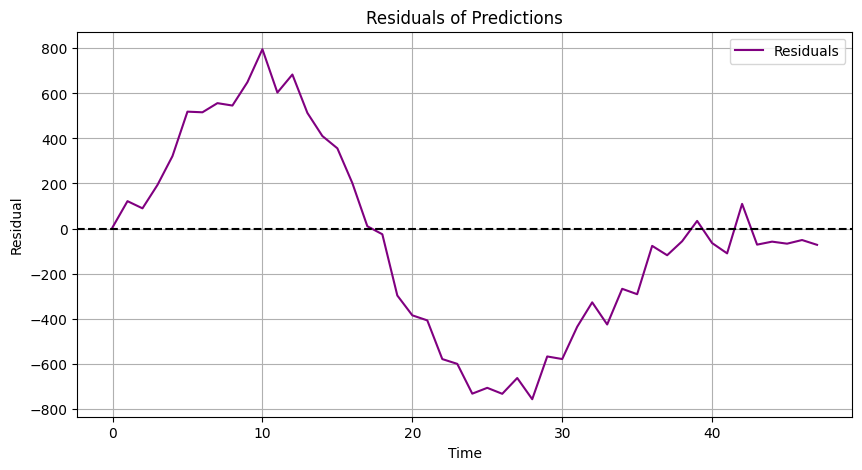

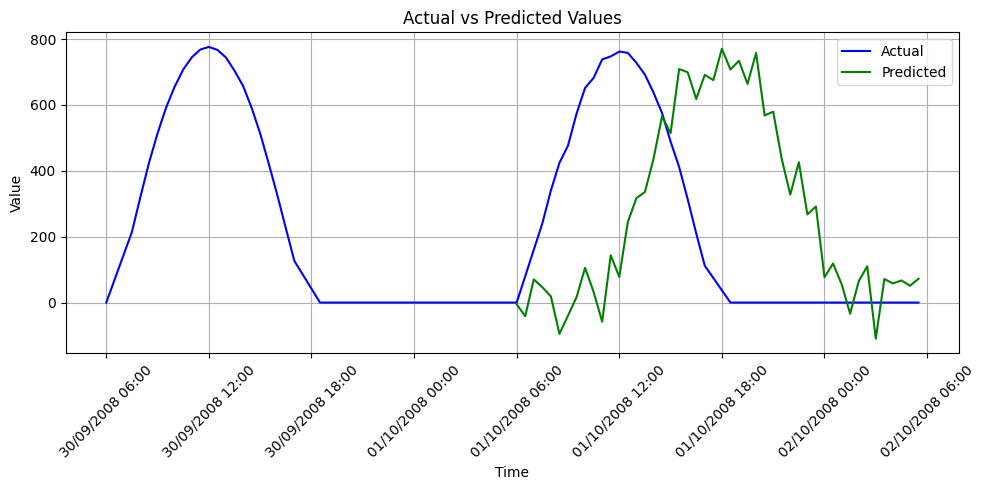

Scaler loaded using joblib from ./data/models_trained_cross/GRU_1_look72_overlap36_scaler_x.pkl
Scaler loaded using joblib from ./data/models_trained_cross/GRU_1_look72_overlap36_scaler_y.pkl
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


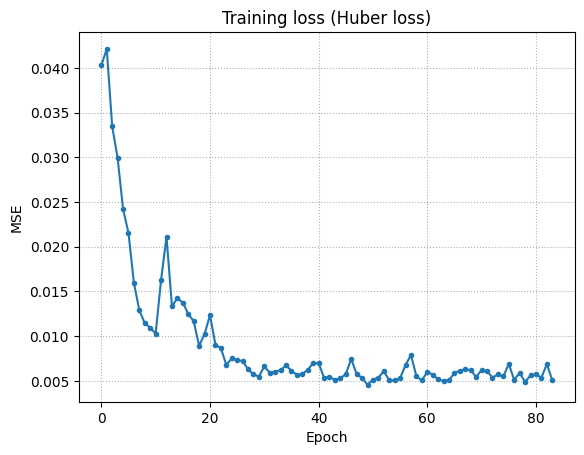

MSE = 45.624639
RMSE = 2081.607667
MAPE = 32.730460
sMAPE = 131.336176
MAE = 34.304201
Huber loss = 33.804241


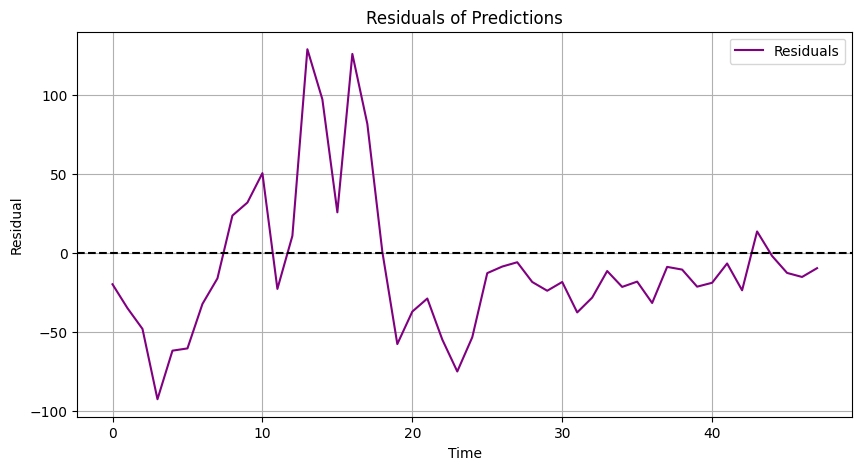

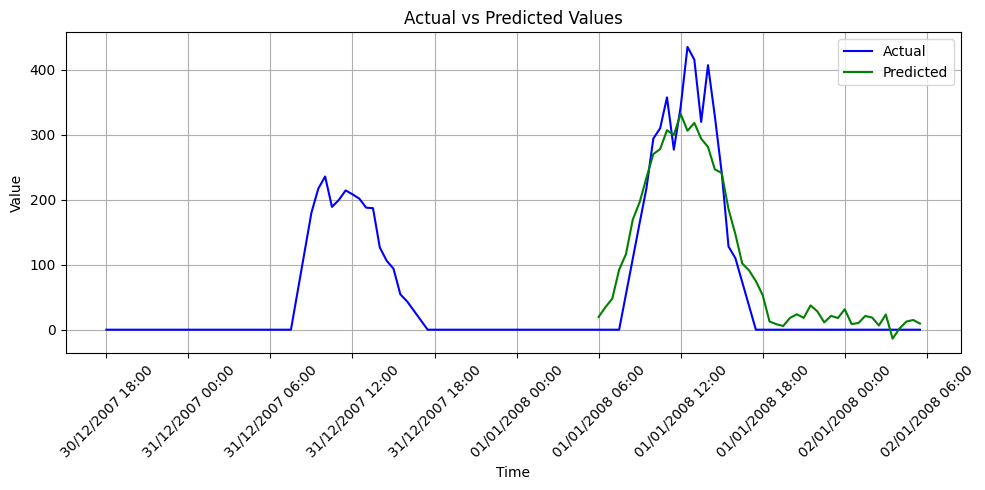

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
MSE = 62.135838
RMSE = 3860.862352
MAPE = 21.786215
sMAPE = 102.386838
MAE = 38.933006
Huber loss = 38.448551


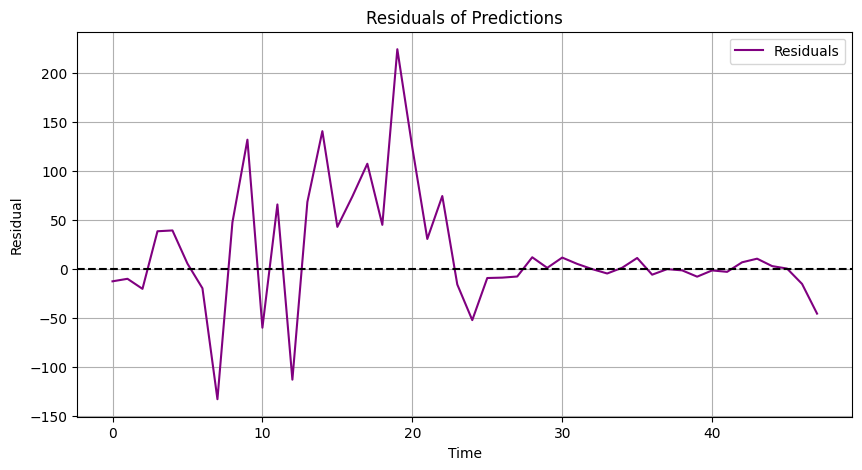

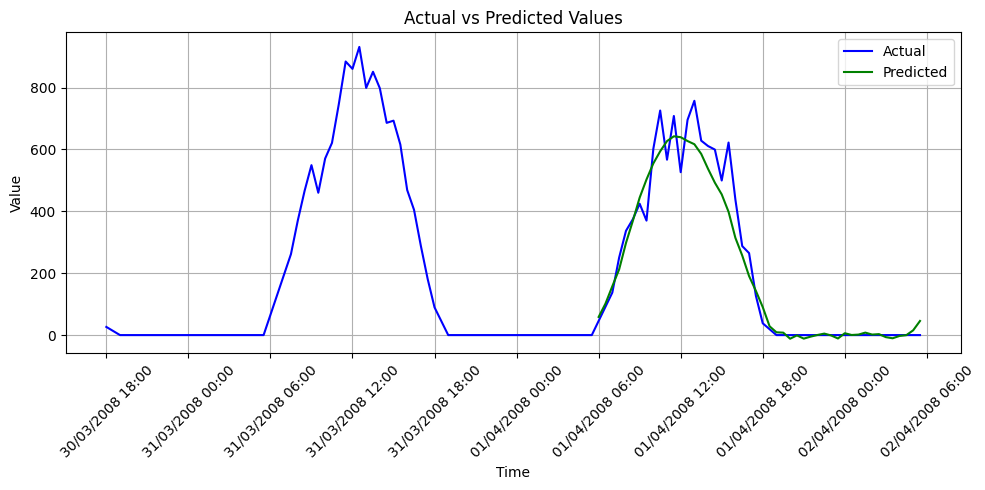

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
MSE = 79.978302
RMSE = 6396.528716
MAPE = 19.140289
sMAPE = 85.206607
MAE = 58.697755
Huber loss = 58.205837


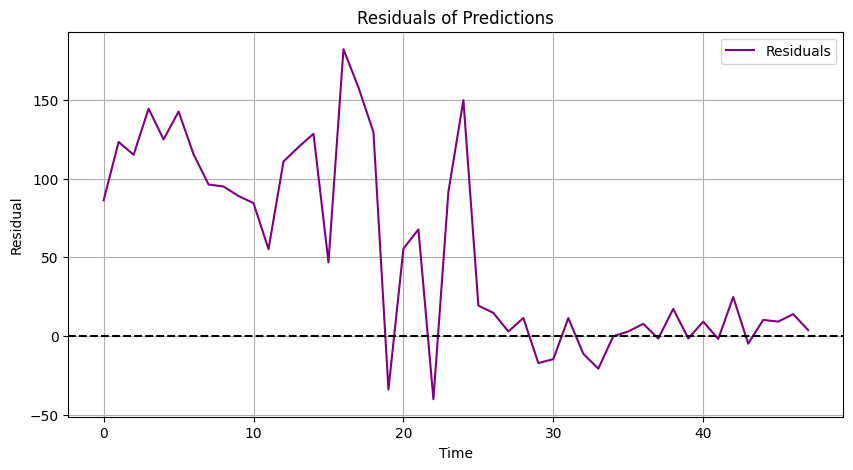

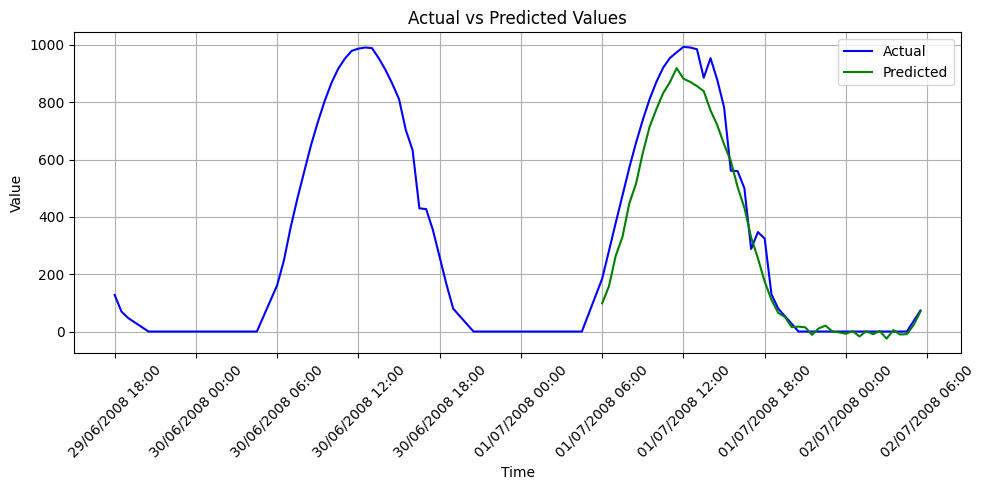

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
MSE = 67.207332
RMSE = 4516.825502
MAPE = 26.610167
sMAPE = 111.306368
MAE = 46.237530
Huber loss = 45.737530


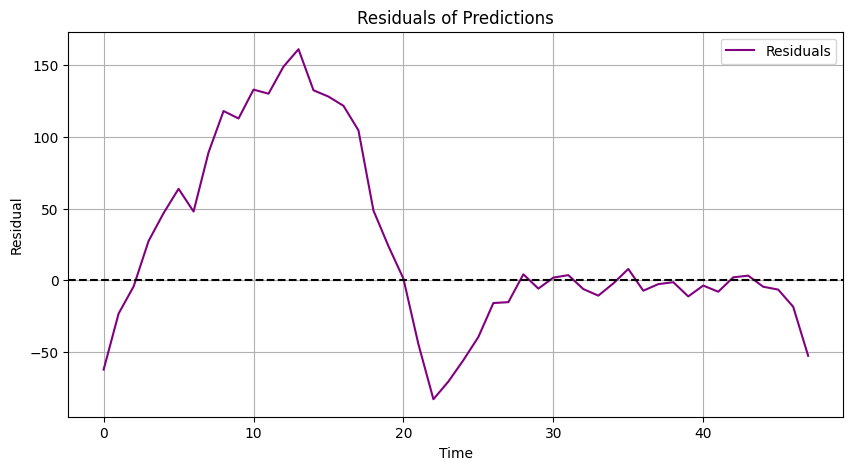

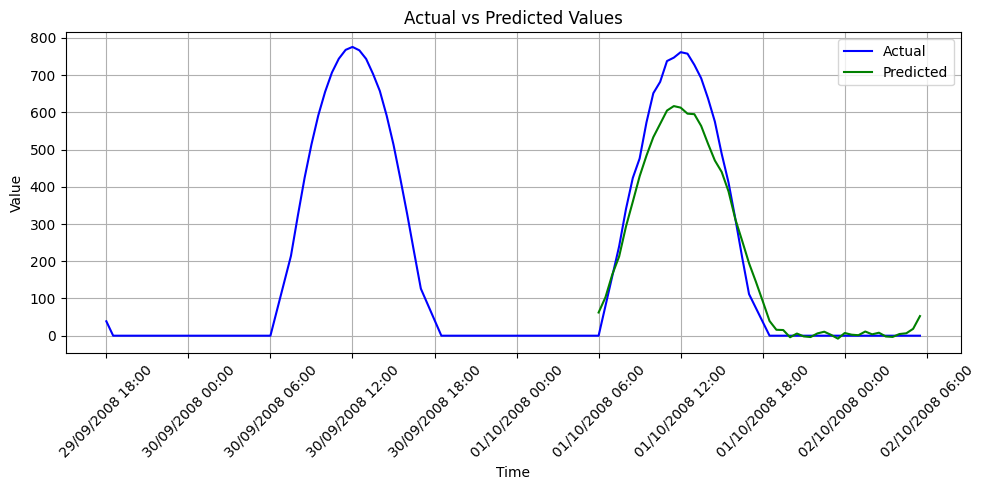

In [20]:
data_for_eval = DataSelectionForEvaluator(dataset)
time_stamps = ['2008-01-01 06:00:00', '2008-04-01 06:00:00', '2008-07-01 06:00:00', '2008-10-01 06:00:00']
for model_conf in model_configurations:
    model = env_dir_options.load_model(os.path.join(model_save_dir, f'{model_conf["model"]["name"]}.keras'))
    # model = env_dir_options.load_model(os.path.join(model_save_dir, f'{model_conf["model"]["name"]}_best.keras'))
    history = json.load(open(os.path.join(model_save_dir, f'{model_conf["model"]["name"]}_history.json')))
    scaler_x = load_scaler(os.path.join(model_save_dir, f'{model_conf["model"]["name"]}_scaler_x.pkl'))
    scaler_y = load_scaler(os.path.join(model_save_dir, f'{model_conf["model"]["name"]}_scaler_y.pkl'))

    # Evaluation of the model in different timestamps

    for iter, time_stamp in enumerate(time_stamps):
        y_true, y_pred, extended_y_true = data_for_eval.data_selection(model_=model,
                                                                       time_stamp=time_stamp,
                                                                       num_look_back_steps=model_conf["model"]["training"][
                                                                           "n_past_steps"],
                                                                       num_forecast_steps=model_conf["model"]["training"][
                                                                           "n_forecast_steps"],
                                                                       columns_for_training=
                                                                       model_conf["model"]["training"][
                                                                           "columns_for_training"],
                                                                       scaler_x=scaler_x,
                                                                       scaler_y=scaler_y,
                                                                       date_index="timestamp",
                                                                       target_column="GHI")
    
        evaluator = ModelEvaluator(y_true, y_pred)
        if iter == 0:
            evaluator.plot_loss(history, 'Huber loss')
        evaluator.metrics()
        evaluator.plot_residuals()
        evaluator.plot_actual_vs_predicted(extended_y_true, model_conf["model"]["training"]["n_past_steps"])